In [44]:
%matplotlib inline

import torch
from torch.autograd import Variable
import numpy as np
import pickle
import matplotlib.pyplot as plt
from src.dataloaders import MHDataLoader
from src.models import SimpleEncoder, SimpleDecoder, ConvEncoder, ConvDecoder
from src.utils.reverse_pianoroll import piano_roll_to_pretty_midi as pr2pm

In [2]:
MIDI_LOW = 48
MIDI_HIGH = 84
DATASET_SIZE = 1000
BATCH_SIZE = 20

dataset = pickle.load(open('../data/mh-midi-data.pickle', 'rb'))
######## divide into train, validation, and test ########
# based on the mean and standard deviation of non zero entries in the data, I've
# found that the most populous, and thus best range of notes to take is from
# 48 to 84 (C2 - C5); this is 3 octaves
dataset = dataset[:DATASET_SIZE, :, MIDI_LOW:MIDI_HIGH, :]

train = dataset[:int(DATASET_SIZE*0.8)]
train_dataloader = MHDataLoader(train)
batched_train = train_dataloader.get_batched_data(BATCH_SIZE)

valid = dataset[int(DATASET_SIZE*0.8):int(DATASET_SIZE*0.9)]
valid_dataloader = MHDataLoader(valid)
batched_valid = valid_dataloader.get_batched_data(BATCH_SIZE)

test = dataset[int(DATASET_SIZE*0.9):]
test_dataloader = MHDataLoader(test)
batched_test = test_dataloader.get_batched_data(BATCH_SIZE)
##############################

In [86]:
input_size = train[0].shape
# enc_input_dim = np.prod(input_size)
# dec_input_dim = enc_input_dim/8
# encoder = SimpleEncoder(enc_input_dim)
# decoder = SimpleDecoder(dec_input_dim, apply_sigmoid=True)
enc_channels = [8, 16]
dec_channels = enc_channels[::-1]
encoder = ConvEncoder(input_size, enc_channels)
decoder = ConvDecoder(encoder.output_dim, dec_channels, input_size, apply_sigmoid=True)

param_dict = torch.load('runs/conv_wbce_1000n_700ep_e-4lr/model_state.pt')
encoder.load_state_dict(param_dict['encoder'])
decoder.load_state_dict(param_dict['decoder'])

In [91]:
song = valid[:8]
song_array = np.concatenate(song[:, 0, :, :], axis=1)
song_var = Variable(torch.FloatTensor(song))
decoded_song_var = decoder(encoder(song_var))
decoded_song = decoded_song_var.view(song.shape).data.numpy()
decoded_song_array = np.concatenate(decoded_song[:, 0, :, :], axis=1)

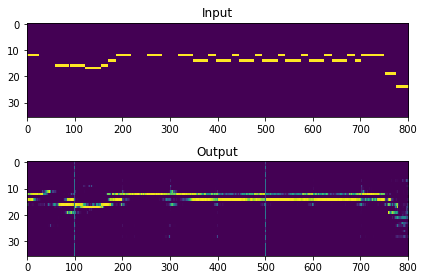

In [92]:
fig = plt.figure()
top = fig.add_subplot(2, 1, 1)
top.set_title("Input")
top.imshow(song_array, aspect='auto')
bottom = fig.add_subplot(2, 1, 2)
bottom.set_title("Output")
bottom.imshow(decoded_song_array, aspect='auto')
fig.subplots_adjust(top=0.95)
fig.tight_layout()
plt.show()

Lets see what the distance is between two consectutive (and therefore, presumably musically similar) clips are in a training song. 

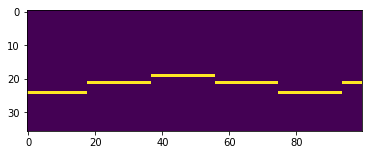

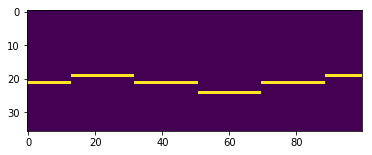

torch.Size([1, 192])
torch.Size([1, 192])


Variable containing:
 106.0270
[torch.FloatTensor of size 1]

In [94]:
one = np.copy(train[:1])
plt.imshow(one[0, 0]) # first channel
plt.show()

two = np.copy(train[1:2])
plt.imshow(two[0, 0]) # first channel 
plt.show()

one_encoded = encoder(Variable(torch.FloatTensor(one)))
two_encoded = encoder(Variable(torch.FloatTensor(two)))
print one_encoded.size()
print two_encoded.size()

def euclid_dist(one, two):
    return torch.sqrt(torch.sum(torch.pow(one - two, 2)))

euclid_dist(one_encoded, two_encoded)

What about when one note is different? (in this case, by a whole step)

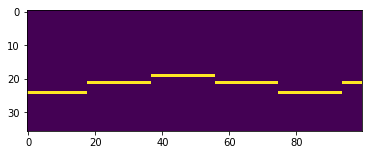

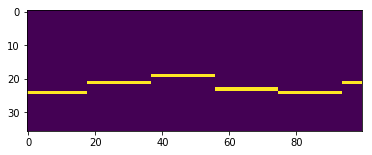

Variable containing:
 53.3961
[torch.FloatTensor of size 1]

In [95]:
one = np.copy(train[:1])
plt.imshow(one[0, 0]) # first channel
plt.show()

two = np.copy(train[:1])
two[:, :, 21, 56:75] = 0 # found these values by guessing
two[:, :, 23, 56:75] = 1
plt.imshow(two[0, 0]) # first channel 
plt.show()

one_encoded = encoder(Variable(torch.FloatTensor(one)))
two_encoded = encoder(Variable(torch.FloatTensor(two)))
euclid_dist(one_encoded, two_encoded)

what about two that are very different?

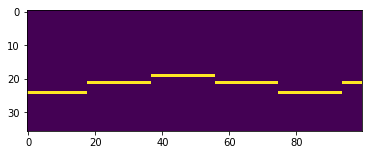

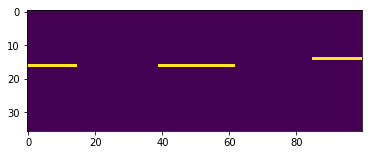

Variable containing:
 155.1919
[torch.FloatTensor of size 1]

In [96]:
one = np.copy(train[:1])
plt.imshow(one[0, 0]) # first channel
plt.show()

two = np.copy(train[567:568])
plt.imshow(two[0, 0]) # first channel 
plt.show()

one_encoded = encoder(Variable(torch.FloatTensor(one)))
two_encoded = encoder(Variable(torch.FloatTensor(two)))
euclid_dist(one_encoded, two_encoded)

Interpolation

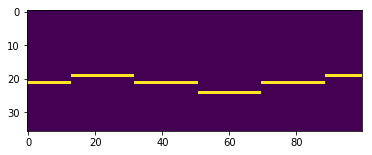

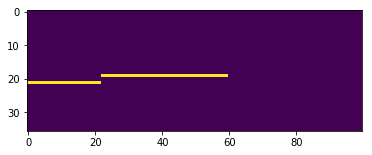

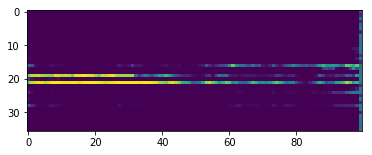

In [97]:
one = np.copy(train[1:2])
plt.imshow(one[0, 0]) # first channel
plt.show()

two = np.copy(train[3:4])
plt.imshow(two[0, 0]) # first channel 
plt.show()

one_encoded = encoder(Variable(torch.FloatTensor(one)))
two_encoded = encoder(Variable(torch.FloatTensor(two)))

bisection = (one_encoded + two_encoded)*0.5
bisdec = decoder(bisection)
bisdec = bisdec.view(one.shape).data.numpy()
# bisdec = np.round(bisdec)
plt.imshow(bisdec[0, 0])
plt.show()


Generating Music by Sampling from the Embedding Space

In [98]:
encoded_train = encoder(Variable(torch.FloatTensor(train))).data.numpy()
mean = np.mean(encoded_train, axis=0)
cov = np.cov(encoded_train, rowvar=False)

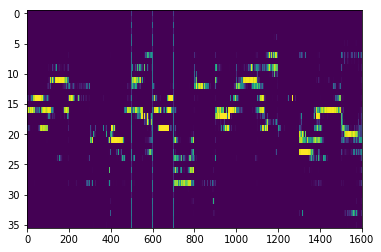

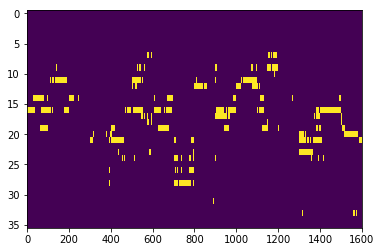

In [102]:
samples = np.random.multivariate_normal(mean, cov, 16)
decoded_samples = decoder(Variable(torch.FloatTensor(samples)))
decoded_song = decoded_samples.view(train[:16].shape).data.numpy()
decoded_song_array = np.concatenate(decoded_song[:, 0, :, :], axis=1)

plt.imshow(decoded_song_array, aspect="auto")
plt.show()

normalized_dsa = np.round(decoded_song_array/np.max(decoded_song_array))
plt.imshow(normalized_dsa, aspect="auto")
plt.show()

midi_array = np.zeros((128, 100*16))
midi_array[MIDI_LOW:MIDI_HIGH] = np.round(decoded_song_array)
outmidi = pr2pm(midi_array.round())
outmidi.write('generated_midi.mid')